In [28]:
import pandas as pd
import numpy as np
import scipy as sp
import gensim
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
%matplotlib inline

In [29]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models, matutils


Importing all Presidential speeches and appending them to a dataframe

In [30]:
from os import path
from pathlib import Path
import os
import glob
from collections import defaultdict
root=r'C:\Users\hartg\Desktop\Professional_Projects\Professional-Projects\MSF_Case_Study\Corpus of Presential Speeches\arthur'
files=os.listdir(root)

#load speeches into a list

docs=list()
for file in files:
    with open(path.join(root,file),'r',encoding='utf-8') as fd:
        txt=fd.read()
        docs.append(txt)

Function that "cleans" the speeches. Re (regular expression) replaces special characters with, in this case, nothing. This will remove the <title=> characters, etc

In [31]:
import re
def clean(doc):
    doc = re.sub(r'[^\w\s]*','',doc)
    doc = re.sub(r'[\s]+', ' ', doc)
    doc = doc.lower().strip()
    return doc

clean the documents associated with the presidential speeches

In [32]:
clean_docs=list()
for doc in docs:
    doc = clean(doc)
    clean_docs.append(doc)

In [33]:
speeches_df=pd.DataFrame(docs)
speeches_df.columns=['text']

In [34]:
speeches_df.head()

,text
0,"<title=""Veto of the Chinese Exclusion Act"">\n<..."
1,"<title=""Address Upon Assuming the Office of th..."
2,"<title=""First Annual Message"">\n<date=""Decembe..."
3,"<title=""Veto of Safety Regulations Bill"">\n<da..."
4,"<title=""Veto of River and Harbors Act"">\n<date..."


In [35]:
new_df=speeches_df['text'].str.split("=",n=1,expand=True)
new_df.columns=['title_bad','title_actual']
new_df.head()

,title_bad,title_actual
0,<title,"""Veto of the Chinese Exclusion Act"">\n<date=""A..."
1,<title,"""Address Upon Assuming the Office of the Presi..."
2,<title,"""First Annual Message"">\n<date=""December 6, 19..."
3,<title,"""Veto of Safety Regulations Bill"">\n<date=""Jul..."
4,<title,"""Veto of River and Harbors Act"">\n<date=""Augus..."


In [36]:
new_df2=new_df['title_actual'].str.split("=",n=1,expand=True)
new_df2.columns=['title','date_and_text']
new_df2.head()

,title,date_and_text
0,"""Veto of the Chinese Exclusion Act"">\n<date","""April 4, 1882"">\nTo the Senate of the United ..."
1,"""Address Upon Assuming the Office of the Presi...","""September 22, 1881"">\nFor the fourth time in ..."
2,"""First Annual Message"">\n<date","""December 6, 1981"">\n\nTo the Senate and House..."
3,"""Veto of Safety Regulations Bill"">\n<date","""July 1, 1882"">\nTo the House of Representativ..."
4,"""Veto of River and Harbors Act"">\n<date","""August 1, 1882"">\nTo the House of Representat..."


In [37]:
new_df3=new_df2['date_and_text'].str.split(">",n=1,expand=True)
new_df3.columns=['date','text']

In [38]:
new_df3.head()

,date,text
0,"""April 4, 1882""",\nTo the Senate of the United States:\nAfter c...
1,"""September 22, 1881""",\nFor the fourth time in the history of the Re...
2,"""December 6, 1981""",\n\nTo the Senate and House of Representatives...
3,"""July 1, 1882""",\nTo the House of Representatives of the Unite...
4,"""August 1, 1882""",\nTo the House of Representatives:\nHaving wat...


In [39]:
speeches=pd.merge(new_df2,new_df3,left_index=True,right_index=True)

In [40]:
speeches.head()

,title,date_and_text,date,text
0,"""Veto of the Chinese Exclusion Act"">\n<date","""April 4, 1882"">\nTo the Senate of the United ...","""April 4, 1882""",\nTo the Senate of the United States:\nAfter c...
1,"""Address Upon Assuming the Office of the Presi...","""September 22, 1881"">\nFor the fourth time in ...","""September 22, 1881""",\nFor the fourth time in the history of the Re...
2,"""First Annual Message"">\n<date","""December 6, 1981"">\n\nTo the Senate and House...","""December 6, 1981""",\n\nTo the Senate and House of Representatives...
3,"""Veto of Safety Regulations Bill"">\n<date","""July 1, 1882"">\nTo the House of Representativ...","""July 1, 1882""",\nTo the House of Representatives of the Unite...
4,"""Veto of River and Harbors Act"">\n<date","""August 1, 1882"">\nTo the House of Representat...","""August 1, 1882""",\nTo the House of Representatives:\nHaving wat...


In [41]:
speeches.drop(['date_and_text'],axis=1,inplace=True)

In [42]:
speeches['title']=speeches.title.str.replace('>\n<date','',regex=True)
speeches.head()

,title,date,text
0,"""Veto of the Chinese Exclusion Act""","""April 4, 1882""",\nTo the Senate of the United States:\nAfter c...
1,"""Address Upon Assuming the Office of the Presi...","""September 22, 1881""",\nFor the fourth time in the history of the Re...
2,"""First Annual Message""","""December 6, 1981""",\n\nTo the Senate and House of Representatives...
3,"""Veto of Safety Regulations Bill""","""July 1, 1882""",\nTo the House of Representatives of the Unite...
4,"""Veto of River and Harbors Act""","""August 1, 1882""",\nTo the House of Representatives:\nHaving wat...


In [43]:
speeches['date']=speeches.date.str.replace('"','',regex=True)
speeches.head()

,title,date,text
0,"""Veto of the Chinese Exclusion Act""","April 4, 1882",\nTo the Senate of the United States:\nAfter c...
1,"""Address Upon Assuming the Office of the Presi...","September 22, 1881",\nFor the fourth time in the history of the Re...
2,"""First Annual Message""","December 6, 1981",\n\nTo the Senate and House of Representatives...
3,"""Veto of Safety Regulations Bill""","July 1, 1882",\nTo the House of Representatives of the Unite...
4,"""Veto of River and Harbors Act""","August 1, 1882",\nTo the House of Representatives:\nHaving wat...


In [44]:
speeches['text']=speeches.text.str.replace("\n",'',regex=True)
speeches.head()

,title,date,text
0,"""Veto of the Chinese Exclusion Act""","April 4, 1882",To the Senate of the United States:After caref...
1,"""Address Upon Assuming the Office of the Presi...","September 22, 1881",For the fourth time in the history of the Repu...
2,"""First Annual Message""","December 6, 1981",To the Senate and House of Representatives of ...
3,"""Veto of Safety Regulations Bill""","July 1, 1882",To the House of Representatives of the United ...
4,"""Veto of River and Harbors Act""","August 1, 1882",To the House of Representatives:Having watched...


Dropping indeces 208,801, and 814 as they were not appropriately transformed upon import

In [45]:
speeches['date']=pd.to_datetime(speeches['date'])

In [46]:
speeches['text']=speeches['text'].str.lower()

Loading stopwords from NLTK

In [47]:
from nltk.corpus import stopwords

In [48]:
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_tags,strip_punctuation,strip_numeric,stem_text
from gensim.parsing.preprocessing import strip_multiple_whitespaces,strip_non_alphanum,remove_stopwords,strip_short
import pattern
import nltk

In [49]:
Filtering=[lambda x: x.lower(),strip_multiple_whitespaces,
          strip_numeric,
          remove_stopwords,
          strip_short]

In [50]:

def preprocess(text):
    result=[]
    for token in preprocess_string(text,Filtering):
        result.append(token)
    return result
speeches['processed_speech']=speeches['text'].map(preprocess)

In [51]:
lemmatizer=nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return[lemmatizer.lemmatize(w) for w in text]


In [52]:
speeches['processed_speech']=speeches.processed_speech.apply(lemmatize_text)

In [53]:
speeches['bigrams']=speeches.processed_speech.apply(lambda row: list(nltk.ngrams(row,2)))

In [54]:
from gensim import corpora,models,similarities
dictionary=corpora.Dictionary(speeches.processed_speech)

Creating the corpus of documents. Doc2Bow counts the number of occurences of each distinct word and converts the word to an integer word ID. Returns a sparse vector

In [55]:
corpus=[dictionary.doc2bow(text) for text in speeches.processed_speech]

Building a TF-IDF Model (Term Frequency Inverse Document Frequency)

In [56]:
tfidf=models.TfidfModel(corpus)
transformed_tfidf = tfidf[corpus]

LDA (Latent Dirichlet Allocation) on TF-IDF

In [57]:
num_topics=5
%time lda = models.LdaModel(transformed_tfidf,id2word=dictionary,num_topics=num_topics,passes=4,alpha=[.01]*num_topics,eta=[.01]*len(dictionary.keys()))

Wall time: 561 ms


In [58]:
lda.show_topics()

[(0,
  '0.009*"deck" + 0.003*"canal" + 0.003*"passenger" + 0.003*"space" + 0.002*"atlantic" + 0.002*"floor" + 0.002*"deck." + 0.002*"uppermost" + 0.002*"nicaragua" + 0.002*"etc.,"'),
 (1,
  '0.005*"chinese" + 0.004*"laborer" + 0.004*"burlingame" + 0.002*"limit," + 0.002*"regulate," + 0.002*"coming" + 0.002*"residence" + 0.001*"passport" + 0.001*"united" + 0.001*"state"'),
 (2,
  '0.000*"canal" + 0.000*"atlantic" + 0.000*"revenue" + 0.000*"distance" + 0.000*"report" + 0.000*"mile" + 0.000*"world&#;s" + 0.000*"water" + 0.000*"nicaragua" + 0.000*",,."'),
 (3,
  '0.005*"appropriation" + 0.004*"remove" + 0.003*"warn" + 0.003*"indian" + 0.003*"signature" + 0.003*"said" + 0.003*"appropriated" + 0.002*"lawmaking" + 0.002*"themselves," + 0.002*"money"'),
 (4,
  '0.006*"government" + 0.004*"congress" + 0.004*"report" + 0.004*"revenue" + 0.004*"question" + 0.004*"state" + 0.003*"year" + 0.003*"secretary" + 0.003*"united" + 0.003*",.of"')]

In [59]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(lda,corpus,dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.036159  0.008330       1        1  85.101997
3      0.025169  0.017588       2        1   6.624649
0      0.006708 -0.018925       3        1   5.511129
1      0.001986 -0.005058       4        1   2.758501
2      0.002296 -0.001936       5        1   0.003720, topic_info=           Term       Freq      Total Category  logprob  loglift
2099     indian  51.000000  51.000000  Default  30.0000  30.0000
104     chinese  15.000000  15.000000  Default  29.0000  29.0000
3431       deck  13.000000  13.000000  Default  28.0000  28.0000
2869    revenue  78.000000  78.000000  Default  27.0000  27.0000
561      report  81.000000  81.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
2769  reduction   0.000181  48.619534   Topic5  -8.4292  -2.3037
671      treaty   0.000178  50.884445   Topic5  -8.4442  -2.3642
407    national   0.000176  44.630486   Topic5  -8.4528  -2.2417
2953    service   0.000173  54.013100   Topic5  -8.4726  -2.4522
2099     indian   0.000171  51.915646   Topic5  -8.4814  -2.4214

[243 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3386      1  0.727834  "uppermost
877       1  0.995071         $,,
880       1  0.998095        $,,.
6364      1  0.770101        (now
907       1  0.941466         ,,.
...     ...       ...         ...
4936      1  0.764933        week
707       1  0.876604        word
5738      1  0.678144       work,
6532      1  0.727607   world&#;s
711       1  0.994504        year

[250 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 1, 2, 3])

In [60]:
count = 1
for doc in speeches['processed_speech']:
    vec=dictionary.doc2bow(doc)
    print("Speech # ",count, lda[vec])
    count=count+1

Speech #  1 [(1, 0.3722932), (3, 0.03641419), (4, 0.59121233)]
Speech #  2 [(4, 0.9979234)]
Speech #  3 [(0, 0.010488207), (3, 0.0762173), (4, 0.90886873)]
Speech #  4 [(0, 0.8994518), (4, 0.09387541)]
Speech #  5 [(3, 0.7002386), (4, 0.2991654)]
Speech #  6 [(4, 0.9995724)]
Speech #  7 [(0, 0.025516927), (3, 0.06748697), (4, 0.89722157)]
Speech #  8 [(0, 0.031934045), (1, 0.010230105), (3, 0.036373932), (4, 0.921441)]
Speech #  9 [(3, 0.03396658), (4, 0.9613113)]
Speech #  10 [(3, 0.76715726), (4, 0.2324457)]
Speech #  11 [(0, 0.5409009), (3, 0.055593997), (4, 0.40327507)]


In [61]:
t=0
for i in lda.show_topics(num_topics=num_topics, num_words=5, log=False, formatted=True):
    print ("Topic # ", t , i)
    t = t + 1

Topic #  0 (0, '0.009*"deck" + 0.003*"canal" + 0.003*"passenger" + 0.003*"space" + 0.002*"atlantic"')
Topic #  1 (1, '0.005*"chinese" + 0.004*"laborer" + 0.004*"burlingame" + 0.002*"limit," + 0.002*"regulate,"')
Topic #  2 (2, '0.000*"canal" + 0.000*"atlantic" + 0.000*"revenue" + 0.000*"distance" + 0.000*"report"')
Topic #  3 (3, '0.005*"appropriation" + 0.004*"remove" + 0.003*"warn" + 0.003*"indian" + 0.003*"signature"')
Topic #  4 (4, '0.006*"government" + 0.004*"congress" + 0.004*"report" + 0.004*"revenue" + 0.004*"question"')


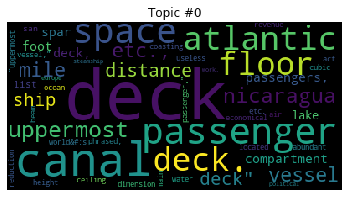

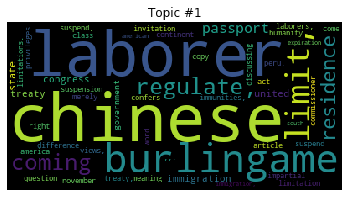

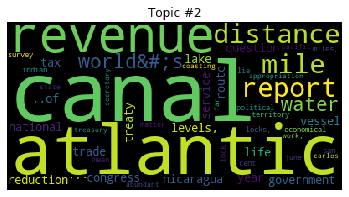

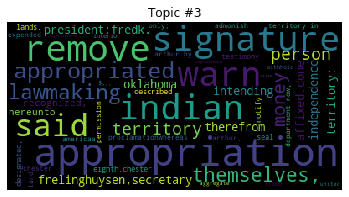

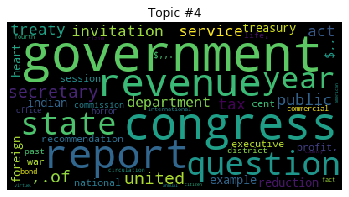

In [62]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
for t in range(lda.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda.show_topic(t,50))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [63]:
topics = [lda[corpus[i]] for i in range(len(speeches))]

def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res
document_topic=\
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

Text(66.5, 0.5, 'Speech')

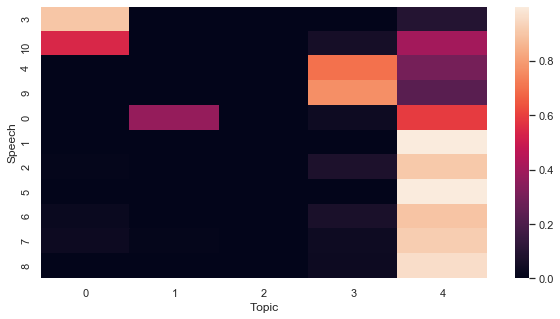

In [67]:
import seaborn as sns
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index])
plt.xlabel('Topic')
plt.ylabel('Speech')

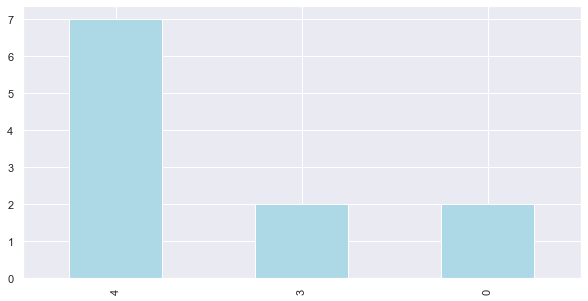

In [65]:
sns.set(rc={'figure.figsize':(10,5)})
document_topic.idxmax(axis=1).value_counts().plot.bar(color='lightblue')